In [113]:
import pandas as pd
import os
import numpy as np
%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
pd.options.display.float_format = '{:,.2f}'.format

# Estimated Calibration Error

ECE:  0.0016607138901949424


Text(0, 0.5, 'Fraction of positive')

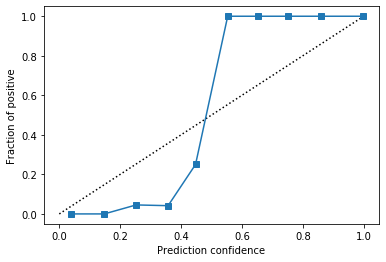

In [120]:
# compute ECE
import torch
import engine
from netcal.metrics import ECE

n_bins = 10
ece = ECE(n_bins)
uncalibrated_score = ece.measure(confidence, ground_truth)
print("ECE: ", uncalibrated_score)


from sklearn.calibration import calibration_curve

# get predicted class
p_classes = [np.argmax(p_arr) for p_arr in confidence]
# print(p_classes)

y_true = [1 if pred == ground_truth[idx] else 0 for idx, pred in enumerate(p_classes)]
# y_true[-1] = 0 # a fake wrong prediction to enable ECE calculation
y_prob = [confidence[idx][l] for idx, l in enumerate(ground_truth)]

# print(list(zip(p_classes, y_true, y_prob))[:5])


fraction_positive, mean_prediction_value = calibration_curve(y_true, y_prob, False, 10)
# print(fraction_positive, mean_prediction_value)
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.plot(mean_prediction_value, fraction_positive, "s-")
plt.xlabel("Prediction confidence")
plt.ylabel("Fraction of positive")